# Language Identification and Similarity

In [1]:
from src.LIdentify import LIdentify, cmf_acc_matrix, plot_acc_cmf
from src.NgramModel import NGModel, tune_alpha, make_cmf
from src.Tokenizer import Tokenizer
from src.Normalizer import normalize_data
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from src.utils import *

In [2]:
# required files (change if needed)
af_file = "data/train.af.txt"
en_file = "data/train.en.txt"
nl_file = "data/train.nl.txt"
xh_file = "data/train.xh.txt"
zu_file = "data/train.zu.txt"

af_val_file = "data/val.af.txt"
en_val_file = "data/val.en.txt"
nl_val_file = "data/val.nl.txt"
xh_val_file = "data/val.xh.txt"
zu_val_file = "data/val.zu.txt"

norm_af_file = "data/normalized.af.txt"
norm_en_file = "data/normalized.en.txt"
norm_nl_file = "data/normalized.nl.txt"
norm_xh_file = "data/normalized.xh.txt"
norm_zu_file = "data/normalized.zu.txt"

# Tri-gram Language Model

### Language Modelling

#### Text/Document Normalization

This section describes the normalization process applied to the training data documents. The normalization steps performed on each paragraph of the document are:

1. Remove leading/trailing whitespace
2. Normalize diacritics to simple characters
3. Replace all digits with '0'
4. Expand abbreviations and acronyms by inserting spaces
5. Split text into sentences, one per line
6. Replace all non-alphanumeric characters (except spaces and newlines) with a single space
7. Convert all text to lowercase

The result of this process is that each line of the new document contains a single normalized sentence.

In [3]:
normalize_data(af_file, norm_af_file)
normalize_data(en_file, norm_en_file)
normalize_data(nl_file, norm_nl_file)
normalize_data(xh_file, norm_xh_file)
normalize_data(zu_file, norm_zu_file)

Document Normalized Successfully!
Document Normalized Successfully!
Document Normalized Successfully!
Document Normalized Successfully!
Document Normalized Successfully!


#### Define and Train a Tri-gram Language Model for Each Language

Since the training data has been normalized, we can now define and train a tri-gram language model for each language represented in the corpus.

A tri-gram language model predicts the probability of a word given the previous two words. The probability can be estimated using the maximum likelihood approach:

$$P(w_t|w_{t-2}, w_{t-1}) = \frac{C(w_{t-2}, w_{t-1}, w_t)}{C(w_{t-2}, w_{t-1})}$$

Where $C(w_{t-2}, w_{t-1}, w_t)$ is the count of the tri-gram $(w_{t-2}, w_{t-1}, w_t)$ in the training data, and $C(w_{t-2}, w_{t-1})$ is the count of the bi-gram $(w_{t-2}, w_{t-1})$. 

To train the tri-gram models, we will follow these steps:

1. Tokenize the normalized training sentences into individual characters.
2. Create a vocabulary of unique words from the tokenized sentences.
3. Introduce special tokens '<' and '>' to mark the beginning and end of each sentence, respectively.
4. Count the frequency of each tri-gram, bigram and unigram, (including the special tokens) in the training data, we will need them later.

Having all the counts, we can compute all the conditional probabilities for the n-gram present in the trainning set and store them. But we will not do that yet to have more flexibility.

In [4]:
af_model = NGModel("af", 3, Tokenizer())
en_model = NGModel("en", 3, Tokenizer())
nl_model = NGModel("nl", 3, Tokenizer())
xh_model = NGModel("xh", 3, Tokenizer())
zu_model = NGModel("zu", 3, Tokenizer())
af_model.train(norm_af_file)
en_model.train(norm_en_file)
nl_model.train(norm_nl_file)
xh_model.train(norm_xh_file)
zu_model.train(norm_zu_file)

Training af model... DONE!
Training en model... DONE!
Training nl model... DONE!
Training xh model... DONE!
Training zu model... DONE!


In [5]:
models = (af_model, en_model, nl_model, xh_model, zu_model)
val_files = (af_val_file, en_val_file, nl_val_file, xh_val_file, zu_val_file)

### Perplexity and Hyperparameter Tuning

The perplexity is one way to measure how well a model performs on a given corpus. It can also be used for language identification, as we will demonstrate. The perplexity of a language model is defined as the inverse geometric mean of the probability assigned by the model to a test set. Mathematically, the perplexity can be calculated as:

$$PP(w_{1:N}) = 2^{-\frac{1}{N} \log_2 P(w_{1:N})}$$

Where:
- $N$ is the number of tokens in the test set
- $P(w_{1:T})$ is the probability assigned by the language model to the sequence.

In the code, we use the natural log probability, so instead of $2$ we use $e$.

However, all the possible n-grams may not be present in the training corpus, which yields a 0 probability for unseen n-grams. This means we cannot compute the perplexity of our model if we have an unseen n-gram.

To handle this situation, we use some smoothing techniques:

**Add-$\alpha$ Smoothing**:
Adding $\alpha$ to each n-gram probability and then normalizing it. A particular case of this is the Laplace smoothing, where $\alpha=1$. The n-gram probability will then have the following form:

$$P(w_t|w_{t-2}, w_{t-1}) = \frac{C(w_{t-2}, w_{t-1}, w_t) + \alpha }{C(w_{t-2}, w_{t-1}) +\alpha |\mathcal{V}|}$$

where $\mathcal{V}$ is the set of vocabulary.

**Interpolation Methods**:
In this case, we combine several models and add some weight to them. This allows us to create a more robust language model by leveraging the strengths of different modeling approaches. The interpolated probability can be calculated as:

$$P(w_t|w_{t-2}, w_{t-1}) = \lambda_3 P_3(w_t|w_{t-2}, w_{t-1}) + \lambda_2 P_2(w_t|w_{t-1}) + \lambda_1 P_1(w_t)$$

where $\lambda_i$ are the weights, and $P_i$ are the individual model probabilities.

Tuning the hyperparameters, such as the smoothing factor $\alpha$ or the weights $\lambda_i$ in the interpolation method, is an important step. This can be done through a grid search or by using gradient descent optimization techniques.

By applying these smoothing techniques and tuning the hyperparameters, we can ensure that our tri-gram language models can handle unseen n-grams and provide accurate perplexity measurements. These tuned models can then be used for various natural language processing tasks, such as language identification, text generation, or perplexity-based model comparison.

#### Perplexity with the Laplace smoothing model (default alpha=1)

Here we compute the perplexity of validation set using Laplace smooting (Add-1).

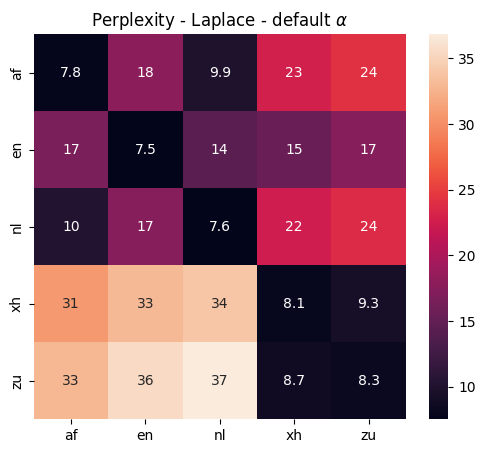

In [6]:
default_parameters = {
    model.name: {
        'alpha': 1,
    } for model in models
}
title = r"Perplexity - Laplace - default $\alpha$"
make_cmf(models, val_files, default_parameters, mode='default', title=title)

#### Tuning Alpha

In order to find a better model as mentioned, we can tune the value of the hyperparameter $\alpha$ using a grid search approach. The goal is to select the value of $\alpha$ that corresponds to the minimal perplexity on the validation set.

The steps are as follows:

1. Define a range of $\alpha$ values to search over, for example $\alpha \in [0.1, 0.2, ..., 1.0]$.
2. Train a separate language model for each $\alpha$ value in the defined range.
3. Evaluate the perplexity of each trained model on the validation set.
4. Select the value of $\alpha$ that results in the lowest validation perplexity. This is the optimal $\alpha$ value for the final model.

Once the optimal $\alpha$ is determined, we can use it to train the final language model on the full training set. This tuned model should demonstrate improved performance compared to the initial model.

In [7]:
alphas = np.arange(0.1, 1, 0.9 / 20)
perplexity_vals = {}
for model, file in zip(models, val_files):
    perplexity_vals[model.name] = tune_alpha(model, file, alphas)

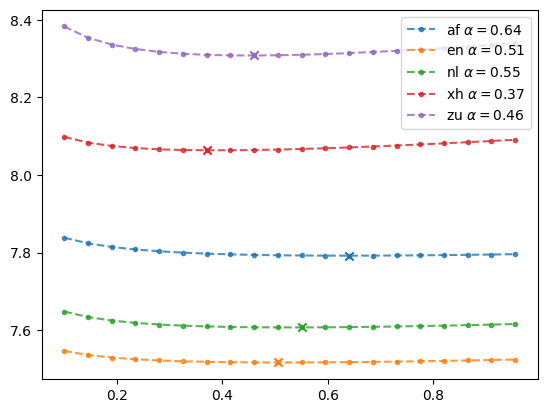

In [8]:
best_alpha = {}
for model, values in zip(models, perplexity_vals.values()):
    k = np.argmin(values)
    plt.plot(alphas, values, '.--', label=fr"{model.name} $\alpha = {alphas[k]:.2f}$", alpha=0.8)
    plt.scatter(alphas[k], values[k], marker='x')
    best_alpha[model.name] = alphas[k]
plt.legend()
plt.show()

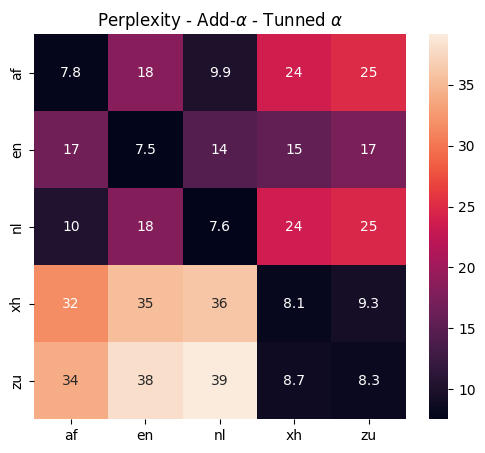

In [9]:
default_parameters = {
    model.name: {
        'alpha': best_alpha[model.name],
    } for model in models
}
title = r"Perplexity - Add-$\alpha$ - Tunned $\alpha$"
make_cmf(models, val_files, default_parameters, mode='default', title=title)

### Perplixity with Interpolation smoothing model
For this case the value of $\lambda_1$ and $\lambda_2$ and $\lambda_3$ were determined through a manual tuning process, aiming to minimize the validation set perplexity.

The values of $\lambda_i$ will determine the importance of the contribution of each models and handle the unseen n-gram as well.

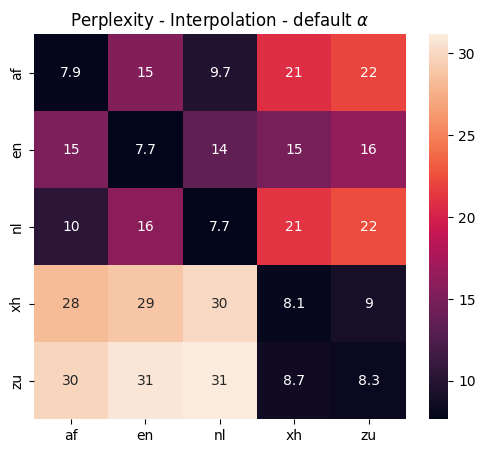

In [10]:
inter_parameters = {
    model.name: {
        'alphas': [0.8, 0.15, 0.05],
    } for model in models
}
title = r"Perplexity - Interpolation - default $\alpha$"
make_cmf(models, val_files, inter_parameters, mode='inter', title=title)

#### English : tri-gram probability with (t,h) as history:

In [11]:
print("Add-alpha smoothing")
probs = defaultdict(float)
for char in en_model.vocab:
    ngram = ('t', 'h', char)
    key = f"P({char}|t,h)"
    val = np.around(en_model.prob(ngram, best_alpha['en']), 5)
    probs[key] = val
probs = sort_dict(probs)
for k, v in probs.items():
    print(f"{k} = {v}")

Add-alpha smoothing
P(e|t,h) = 0.6801
P( |t,h) = 0.10159
P(a|t,h) = 0.08302
P(i|t,h) = 0.04469
P(o|t,h) = 0.03796
P(r|t,h) = 0.03386
P(n|t,h) = 0.00461
P(s|t,h) = 0.00333
P(>|t,h) = 0.00286
P(u|t,h) = 0.00239
P(y|t,h) = 0.00198
P(w|t,h) = 0.00071
P(d|t,h) = 0.00064
P(l|t,h) = 0.00057
P(m|t,h) = 0.00044
P(c|t,h) = 0.0003
P(t|t,h) = 0.00024
P(p|t,h) = 0.00017
P(f|t,h) = 0.0001
P(b|t,h) = 0.0001
P(h|t,h) = 3e-05
P(g|t,h) = 3e-05
P(0|t,h) = 3e-05
P(v|t,h) = 3e-05
P(<|t,h) = 3e-05
P(k|t,h) = 3e-05
P(x|t,h) = 3e-05
P(j|t,h) = 3e-05
P(z|t,h) = 3e-05
P(q|t,h) = 3e-05


In [12]:
()

()

In [13]:
print("Interpolation smoothing")
probs = defaultdict(float)
for char in en_model.vocab:
    ngram = ('t', 'h', char)
    key = f"P({char}|t,h)"
    val = np.round(en_model.probInt(ngram, inter_parameters['en']['alphas']), 5)
    probs[key] = val
probs = sort_dict(probs)
for k, v in probs.items():
    print(f"{k} = {v}")

Interpolation smoothing
P(e|t,h) = 0.61836
P( |t,h) = 0.10676
P(a|t,h) = 0.08975
P(i|t,h) = 0.05979
P(o|t,h) = 0.04418
P(r|t,h) = 0.03323
P(n|t,h) = 0.00773
P(t|t,h) = 0.00601
P(s|t,h) = 0.00582
P(u|t,h) = 0.00465
P(y|t,h) = 0.00391
P(>|t,h) = 0.00309
P(l|t,h) = 0.00257
P(d|t,h) = 0.00214
P(h|t,h) = 0.00188
P(c|t,h) = 0.00182
P(m|t,h) = 0.00165
P(w|t,h) = 0.00145
P(p|t,h) = 0.00099
P(f|t,h) = 0.00095
P(g|t,h) = 0.00076
P(b|t,h) = 0.00068
P(0|t,h) = 0.0006
P(v|t,h) = 0.00043
P(<|t,h) = 0.00037
P(k|t,h) = 0.0002
P(x|t,h) = 8e-05
P(j|t,h) = 7e-05
P(z|t,h) = 4e-05
P(q|t,h) = 3e-05


### Text Generation

With the hyperparameter-tuned models, we can now generate text character by character. The code was designed to generate text from a random starting point or from some specific starting words/text. The text generation process is as follows:

* With a starting text: Split the text into a list of characters and add the starting marker '<' at the beginning.
* From nothing: We start with the starting sentence, then we use the bigram model to form the first two characters, i.e., ('<', '*').

Now we do the following process until we meet the ending markers:
   * Compute all $p(x|w_{t-2}w_{t-1})$, for all $x\in\mathcal{V}$
   * Normalize these probabilities to ensure they form a valid probability distribution.
   * Then we use `np.random.multinomial` to sample the next character according to the normalized probabilities.

Note that the process described above is also used for the bigram model at the beginning if we do not specify any starting character.

The probability are computed according to the specific smoothing method.

#### Add-$\alpha$ smoothing

Generating text with the model using Add-$\alpha$ smoothing method.

In [14]:
for model in models:
    print(f"Model : {model.name}")
    gen_text = model.generateSentence(start='th', params={'alpha': best_alpha[model.name]})
    print(gen_text)
    pp = model.perplexity(gen_text, params={'alpha': best_alpha[model.name]}, doc=False)
    print(f"Perplexity : {pp}")
    print("*" * 10)
    print()

Model : af
<thervoort waandde 00 0 0 0 0 0 0 0 0 0 maja die nomgeke bunin maar n 0 vland ts see en hetren en rupte>
Perplexity : 6.015571133158842
**********

Model : en
<this of the proplart tioloposeled dommachran that inalin meater ithe as or fores ther cuseve of de con>
Perplexity : 6.122465912744945
**********

Model : nl
<thogen nontwijker hemilijd waareksannikaals de belijkstofis veeuws ist>
Perplexity : 7.988862180757082
**********

Model : xh
<thawa bukuphathamadla ya lelela 00 0 000 fihle lelo ye kugq>
Perplexity : 6.2378747578044615
**********

Model : zu
<thilimithiwangesi ngengump jontu>
Perplexity : 6.6946293094048075
**********



#### Interpolation smoothing

Generating text using the model with Interpolation smoothing methods.

In [15]:
for model in models:
    param = inter_parameters[model.name]
    print(f"Model : {model.name}")
    gen_text = model.generateSentence(start='', params=param, mode='inter')
    print(gen_text)
    pp = model.perplexity(gen_text, params=param, doc=False, mode='inter')
    print(f"Perplexity : {pp}")
    print("*" * 10)
    print()

Model : af
<r ie pole do diegs gehark has die daar ingnofloems bewtengproosliaan van eurboorde vrdie eek vereen barteepe bligheibegsendwend>
Perplexity : 10.027307421558243
**********

Model : en
<jaitivend wancy etrencepimillifhis ortele eyper thwitiouriaillsto  thot ank r forai mosple asimut his desigilllof eclogy or ortivareflue of ho erigholn this tere tri ke culthes to cansys f tworty infareve the sahial mand vanontly go soke anne s the part was gor thern loweer its celeois b bu yelsouicaneasere the ploscrid tle dura>
Perplexity : 10.21404185664123
**********

Model : nl
<oot gerd arnen der hoeme nsteguurin tur>
Perplexity : 9.773552472781905
**********

Model : xh
<wa yaajembaxesi ngeelando pentu idisa ezo ntu cla yemza ehetya zi monwafrikals ezi so ejalamayi ke si yza utrme abenzulali>
Perplexity : 9.915887863733841
**********

Model : zu
<0 kwakho ngungokhincezimushungesifuthilela>
Perplexity : 7.491217754755037
**********



## Language Identification

Here we use the trained models to identify the language of each sentence in the testing set, and compute the overall accuracy. To identify the language used in each sentence, we apply the following process:

1. Compute the perplexity of the sentence using each of the trained language models.
2. The predicted label (language) is then determined by the model with the lowest perplexity.

This approach assigns each sentence to the language model that can most effectively encode and predict the sequence of characters in that sentence, which indicates the most likely language.

The accuracy of the language identification is then calculated as the fraction of sentences that are correctly classified compared to the ground truth labels.

In [16]:
labels = [model.name for model in models]
x, y = read_test('data/test.lid.txt')

### Add-$\alpha$ model

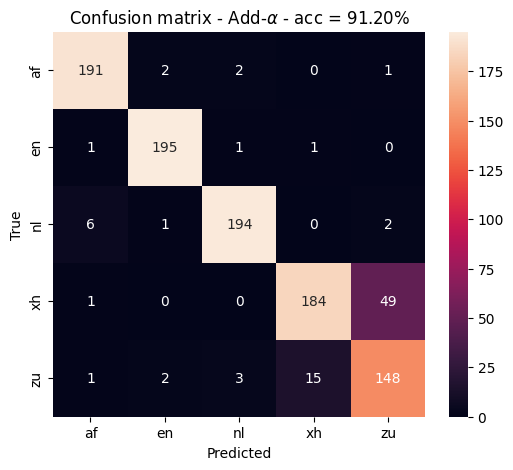

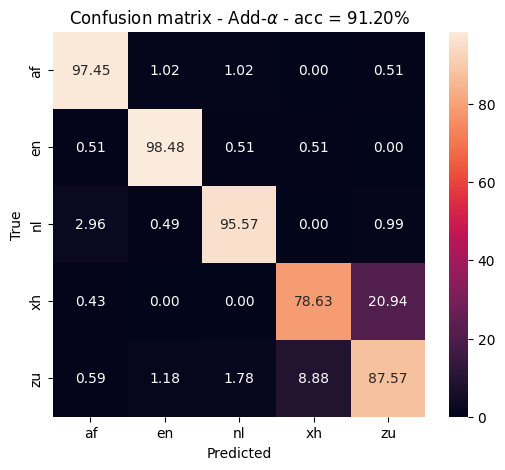

In [17]:
alphas = {k: {'alpha': v} for k, v in best_alpha.items()}
identifiers = LIdentify(models, mode='default', params=alphas)

cmf = cmf_acc_matrix(identifiers, x, y)
accuracy = 100 * np.diag(cmf).sum() / cmf.sum()
cmf_norm = 100*cmf / cmf.sum(axis=1)[:, np.newaxis]

plot_acc_cmf(cmf, accuracy, labels, title=r'Add-$\alpha$', fmt='.0f')
plot_acc_cmf(cmf_norm, accuracy, labels, title=r'Add-$\alpha$', fmt='.2f')
plt.show()

### Interpolation model

In [18]:
inter_parameters = {
    model.name: {
        'alphas': [0.8, 0.15, 0.05],
    } for model in models
}

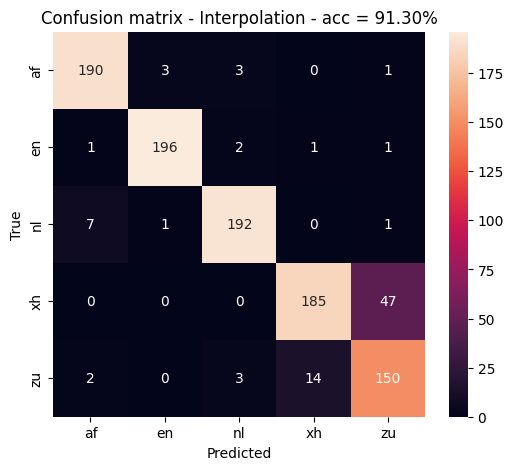

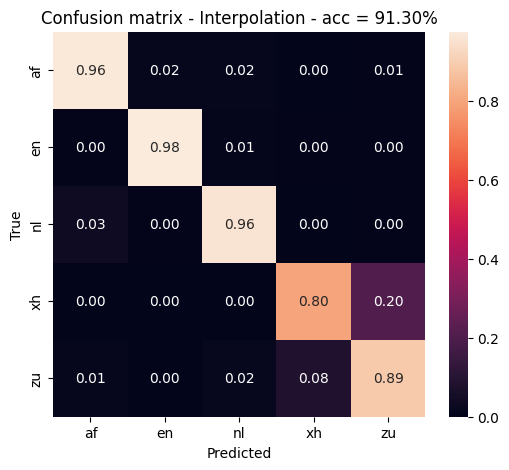

In [19]:
identifiers2 = LIdentify(models, mode='inter', params=inter_parameters)
cmf2 = cmf_acc_matrix(identifiers2, x, y)
accuracy2 = 100 * np.diag(cmf2).sum() / cmf2.sum()
cmf_norm2 = cmf2 / cmf2.sum(axis=1)[:, np.newaxis]


plot_acc_cmf(cmf2, accuracy2, labels, title=r'Interpolation', fmt='.0f')
plot_acc_cmf(cmf_norm2, accuracy2, labels, title=r'Interpolation', fmt='.2f')
plt.show()

# Byte-Pair Encoding for Language Similarity

In [20]:
from src.BytePairEncoding import BytePairEncoding, plot_intersection_cmf

## Byte-Pair Encoding (BPE)

Byte-Pair Encoding (BPE) is an algorithm that allows us to learn a compact subword vocabulary from a training corpus using the following process:

1. **Initialization**:
   - Initialize the tokens at the character level.
   - Create the initial vocabulary $\mathcal{V}$ using the unique characters from the tokens.

2. **Repeat for $k$ times**:
   - Find the most frequent pair of adjacent tokens $t_L, t_R$ in the corpus.
   - Create a new token $t_{new} = t_L + t_R$ (merge the pair).
   - Add the new token $t_{new}$ to the vocabulary $\mathcal{V}$.
   - Replace all occurrences of $t_L, t_R$ with $t_{new}$ in the corpus.

3. **Record the history of the merging process**:
   - The sequence of token merges is recorded and can be applied to tokenize new text corpus.

The resulting vocabulary $\mathcal{V}$ will have $k + |$Initial Characters$|$ tokens after the $k$ iterations. If the algorithm is run for a very large number of merges, the vocabulary may contain complete words from the training corpus, which may not be the most useful representation.

Therefore, the appropriate number of merges should be chosen to obtain a compact set of subword units that can effectively represent the original text corpus. This allows the model to handle rare and out-of-vocabulary words by decomposing them into these learned subword units.

In [21]:
language = ('af', 'en', 'nl', 'xh', 'zu')
train_files = (norm_af_file, norm_en_file, norm_nl_file, norm_xh_file, norm_zu_file,)

In [22]:
bpes = {
    lang: BytePairEncoding(name=lang) for lang in language
}

In [23]:
for file, lang in zip(train_files, bpes.keys()):
    bpes[lang].init(file)
    bpes[lang].learn(max_iter=100)

Token learning for: af
Encoding Done
Token learning for: en
Encoding Done
Token learning for: nl
Encoding Done
Token learning for: xh
Encoding Done
Token learning for: zu
Encoding Done


### Ten first merges for each language

In [25]:
for lang in language:
    print(f"Language : {lang}")
    for i, merge in enumerate(bpes[lang].history[:10]):
        print(f"{i + 1:<2} Merge : {merge[0]}+{merge[1]} --> {merge[2]}")
    print("=" * 25)

Language : af
1  Merge : e+_ --> e_
2  Merge : n+_ --> n_
3  Merge : e+r --> er
4  Merge : i+e_ --> ie_
5  Merge : d+ie_ --> die_
6  Merge : s+_ --> s_
7  Merge : t+_ --> t_
8  Merge : 0+_ --> 0_
9  Merge : a+n --> an
10 Merge : e+l --> el
Language : en
1  Merge : e+_ --> e_
2  Merge : s+_ --> s_
3  Merge : t+h --> th
4  Merge : d+_ --> d_
5  Merge : n+_ --> n_
6  Merge : e+r --> er
7  Merge : a+n --> an
8  Merge : t+_ --> t_
9  Merge : th+e_ --> the_
10 Merge : i+n --> in
Language : nl
1  Merge : n+_ --> n_
2  Merge : e+_ --> e_
3  Merge : e+n_ --> en_
4  Merge : e+r --> er
5  Merge : t+_ --> t_
6  Merge : d+e_ --> de_
7  Merge : s+_ --> s_
8  Merge : a+a --> aa
9  Merge : 0+_ --> 0_
10 Merge : e+l --> el
Language : xh
1  Merge : a+_ --> a_
2  Merge : e+_ --> e_
3  Merge : i+_ --> i_
4  Merge : o+_ --> o_
5  Merge : a+n --> an
6  Merge : k+u --> ku
7  Merge : n+g --> ng
8  Merge : e+l --> el
9  Merge : i+n --> in
10 Merge : e+n --> en
Language : zu
1  Merge : a+_ --> a_
2  Merge : i+_

## Vocabulary intersection after 100 merge

In [31]:
intersection = np.zeros((5, 5))
for i, lang1 in enumerate(language):
    for j, lang2 in enumerate(language):
        vocab1 = bpes[lang1].vocab
        vocab2 = bpes[lang2].vocab
        intersection[i, j] = len(vocab1.intersection(vocab2))
percentage_intersection = (intersection / np.diag(intersection))*100

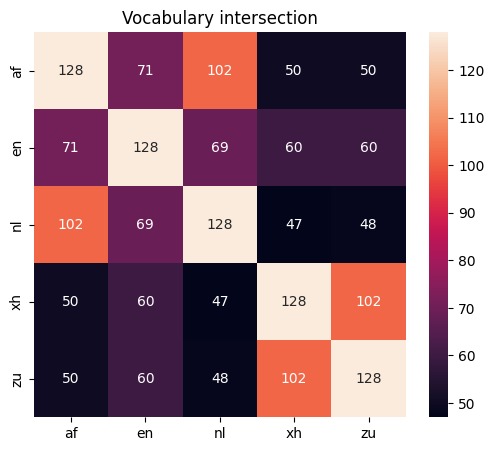

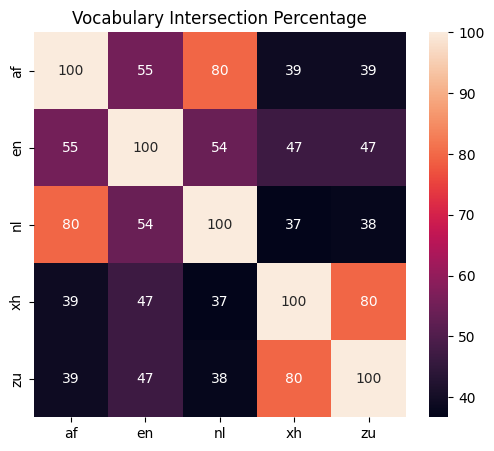

In [35]:
plot_intersection_cmf(intersection, language, title="Vocabulary intersection", fmt='.0f')
plot_intersection_cmf(percentage_intersection, language, title="Vocabulary Intersection Percentage", fmt='.0f')

From the given confusion matrix, we can observe the following:

1. Zulu and Xhosa share 80% of their vocabulary.
2. Dutch and Afrikaans share 80% of their vocabulary.
3. Afrikaans and English share 57% of their vocabulary.
4. Dutch and English share 55% of their vocabulary.
5. Xhosa and  Dutch share 38% of their vocabulary.

These results suggest that the languages in the first two pairs (Zulu-Xhosa and Dutch-Afrikaans) share a significant amount of common vocabulary, likely due to their close linguistic relationship. On the other hand, Afrikaans and English, as well as Dutch and English, share a smaller percentage of their vocabulary, indicating a more distant relationship.


As I do not know the underlaying history on thse languages (except english), I did not really have an expect results. But after some discussion with friend, I realize that these results make sense. I addition ation to that I had look on this web site http://www.elinguistics.net/Compare_Languages.aspx that quantify the genetic proximity of two languages, and report the following results (**Genetic Proximity**):
1. Zulu and Xhosa: 20.6 (Closely related)
2. Dutch and Afrikaans: 2.8 (Very closely related)
3. Afrikaans and English: 22.5 (Closely related)
4. Dutch and English: 21.5 (Closely related)
5. Xhosa and  Dutch: not detected (not related)

As explained there the scale are interpreted as follow:
- Between 1 and 30: Highly related languages. Protolanguage (common "ancestor") between several centuries and approx. 2000 years.
- Between 30 and 50: Related languages. Protolanguage approx. between 2000 and 4000 years.
- Between 50 and 70: Remotely related languages. Protolanguage approx. between 4000 and 6000 years. Chance interference increases with values above 60-62.
- Between 70 and 78: Very remotely related languages. Protolanguage approx. older than 6000 years - but high potential of interference with chance resemblance.
- Between 78 and 100: No recognizable relationship: the few resemblances measured are more likely to be due to chance than to common origin.


These result of genetic proximity support the result tha we obtain from our vocabulary sharing percentage.

According to that, we can effectivelly measure the similarity of two language, by applying a BPE on a given corpus on the two language an then compare the overlapping vocabulary generated by the BPE. Additionally, these measure reflect the perplexity values measured on the validation set. Because, on the similar language the perplexity value are close and low, and on distant language we have high perplexity.


# References
* **Herman Kamper**, NLP817, https://www.kamperh.com/nlp817/, Stellenbosch University
* **Daniel Jurafsky, James H. Martin**, Speech and Language Processing, 3rd Edition, Stanford University, University of Colorado at Boulder
* **Compare Language** http://www.elinguistics.net/Compare_Languages.aspx
